# [EDA] Spatial Contexts for Los Angeles

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

%matplotlib inline
plt.style.use('fivethirtyeight')

## CalEPA Data

### GeoPandas DataFrame of LA County

In [2]:
# Original Pandas df of Los Angeles 
ces_la = pd.read_csv("../data/CalEPA/ces_losangeles.csv", index_col=0)

In [3]:
# Convert to GeoPandas with coordinates (longitude, latitude)
gpd_la = gpd.GeoDataFrame(ces_la, geometry=gpd.points_from_xy(ces_la.Longitude, ces_la.Latitude))

In [4]:
gpd_la.head()

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile Range,Ozone,...,Children < 10 years (%),Pop 10-64 years (%),Elderly > 64 years (%),Hispanic (%),White (%),African American (%),Native American (%),Asian American (%),Other/Multiple (%),geometry
0,6037204920,2751,Los Angeles,90023,Los Angeles,-118.197497,34.017500,82.39,95-100% (highest scores),0.048,...,13.34,72.59,14.07,97.27,1.71,0.84,0.0,0.00,0.18,POINT (-118.19750 34.01750)
1,6037542402,3306,Los Angeles,90221,Compton,-118.212413,33.881969,80.71,95-100% (highest scores),0.043,...,11.34,77.53,11.13,65.34,0.54,33.55,0.0,0.57,0.00,POINT (-118.21241 33.88197)
2,6037543202,5124,Los Angeles,90220,Compton,-118.230032,33.879862,79.29,95-100% (highest scores),0.042,...,18.60,72.48,8.92,78.14,1.09,15.67,0.0,4.84,0.25,POINT (-118.23003 33.87986)
3,6037203300,2000,Los Angeles,90033,Los Angeles,-118.207788,34.058872,77.35,95-100% (highest scores),0.049,...,7.70,84.50,7.80,75.55,2.85,10.45,0.0,6.95,4.20,POINT (-118.20779 34.05887)
4,6037291220,3640,Los Angeles,90247,Los Angeles,-118.286709,33.877139,77.25,95-100% (highest scores),0.041,...,12.77,73.16,14.07,69.34,3.98,8.43,0.0,16.32,1.92,POINT (-118.28671 33.87714)


### Shapefile of LA County

In [5]:
shape_la = gpd.read_file("../data/LAShape/County_Boundary.shp")

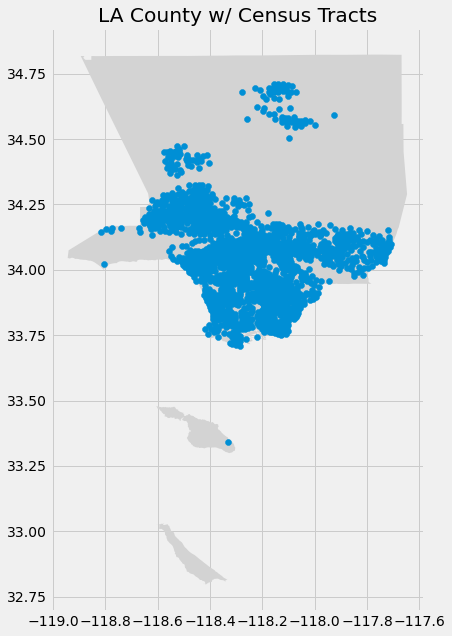

In [11]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(ax=ax)
plt.title("LA County w/ Census Tracts");

## Shapefile of LA County w/ CES 4.0 Percentile Scores, Pollution Burden, and Population Characteristics

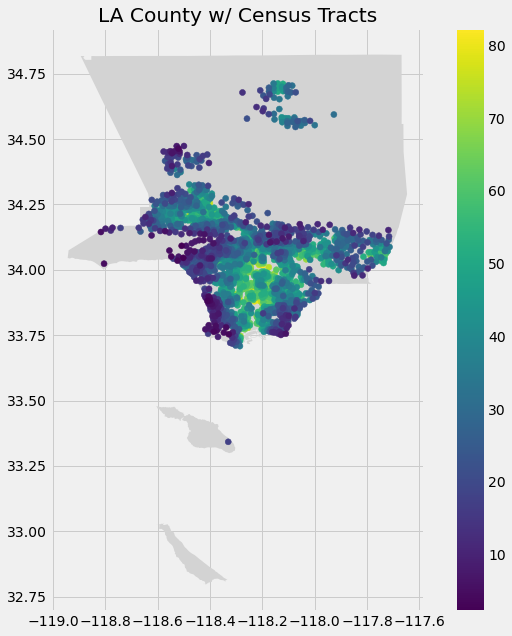

In [13]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(column='CES 4.0 Score', ax=ax, legend=True)
plt.title("LA County w/ Census Tracts");

## Shapefile of LA County w/ Population Characteristics

Based on our initial EDA in the `1.Introduction` notebook, we learn that several of our population characteristics are highly correlated with our CES 4.0 Percentile Scores. Can we see this visually as well? 

Among demographics, Hispanic and White had the highest correlation, and among characteristics, Education and Poverty did as well. Let's take a look at these first.

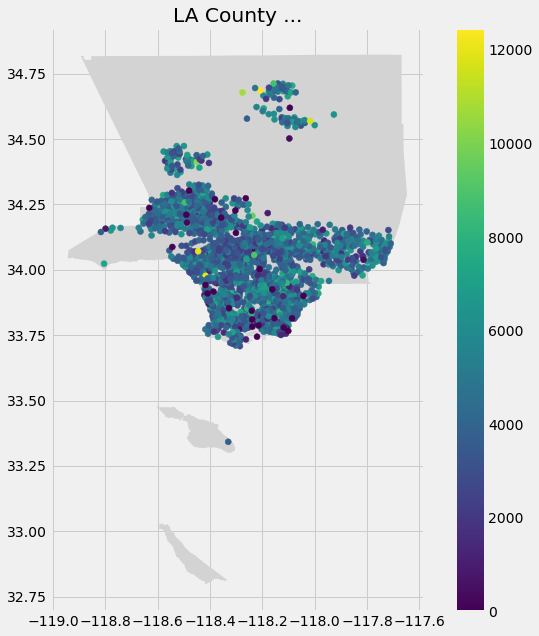

In [16]:
fig, ax = plt.subplots(figsize = (10,10))
shape_la.plot(ax=ax, color='lightgrey')
gpd_la.plot(column='Total Population', ax=ax, legend=True)
plt.title("LA County ...");

## NASA SoCAB Land Cover